In [1]:
import sys

import numpy as np
np.random.seed(0)
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import scipy
import scipy.stats

import cobra
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})
import arviz as az

from csv import writer
import emll

import cloudpickle
import os
os.getcwd()

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


'c:\\Users\\user\\Documents\\research\\benchmarking\\glycolysis'

In [2]:
os.chdir('results')

In [3]:
run_name = '20230706_glycolysis_A_advi'

with open(run_name + '.pgz', "rb") as f:
    pickle_jar = cloudpickle.load(f)



In [ ]:
pickle_jar

In [5]:
def ADVI_elasticities(pickle_jar):
    trace = pickle_jar['trace']
    e_labels = pickle_jar['e_labels']

    postEx = np.squeeze(trace['posterior']['Ex'].to_numpy()) # (1000, 91, 80)
    postEy = np.squeeze(trace['posterior']['Ey'].to_numpy()) # (1000, 91, 14)

    Ex_hdi = az.hdi(trace['posterior']['Ex'])['Ex'].to_numpy() #(91, 80, 2)
    Ey_hdi = az.hdi(trace['posterior']['Ey'])['Ey'].to_numpy() #(91, 14, 2)
    ex_vi = Ex_hdi.reshape((Ex_hdi.shape[0]*Ex_hdi.shape[1],-1))
    ey_vi = Ey_hdi.reshape((Ey_hdi.shape[0]*Ey_hdi.shape[1],-1))
    e_all_vi = np.transpose(np.vstack([ex_vi, ey_vi]))
    e_df_vi = pd.DataFrame(e_all_vi, columns=e_labels)
    # e_df_vi.to_csv(f'{run_name}_predicted_elasticities.csv')

    a = postEx.reshape((-1, postEx.shape[1]*postEx.shape[2]))
    b = postEy.reshape((-1, postEy.shape[1]*postEy.shape[2]))
    c = np.hstack([a, b])

    medians = pd.DataFrame(c, columns=e_labels).median().to_numpy()

    #with open(f'{run_name}_predicted_elasticities.csv', 'a', newline='') as f:
    #    writer(f).writerow(['median'] + list(medians))
    #    f.close()
    
    return medians

In [22]:
def ADVI_CCs_hdi(pickle_jar, medians, cc_type, run_name):
    """
    Ex_hdi is the hdi of the posterior Ex trace as a numpy array
    """
    trace = pickle_jar['trace']
    trace_prior = pickle_jar['trace_prior']
    ll = pickle_jar['ll']
    m_labels = pickle_jar['m_labels']
    r_labels = pickle_jar['r_labels']
    y_labels = pickle_jar['y_labels']

    Ex_hdi = az.hdi(trace['posterior']['Ex'])['Ex'].to_numpy() #(13, 8, 2)
    Ey_hdi = az.hdi(trace['posterior']['Ey'])['Ey'].to_numpy() #(13, 2, 2)

    priorEx_hdi = az.hdi(trace_prior['prior']['Ex'])['Ex'].to_numpy() #(13, 8, 2)Ex_hdi = az.hdi(trace['posterior']['Ex'])['Ex'].to_numpy() #(13, 8, 2)
    
    a = np.transpose(Ex_hdi,(2, 0, 1))
    b = np.transpose(priorEx_hdi,(2, 0, 1))

    medians = medians.reshape((1, len(r_labels),-1))

    if cc_type=='mcc':
        cc_mb = np.array([ll.metabolite_control_coefficient(Ex=ex) for ex in a])   
        cc_prior = np.array([ll.metabolite_control_coefficient(Ex=ex) for ex in b]) 
        medians = np.array([ll.metabolite_control_coefficient(Ex=ex) for ex in medians])
        hdi_upper = pd.DataFrame(cc_mb[0], index=m_labels, columns=r_labels).rename_axis(('Reactions'))
        hdi_lower = pd.DataFrame(cc_mb[1], index=m_labels, columns=r_labels).rename_axis(('Reactions'))
        cc_hdi = pd.concat({'upper': hdi_upper, 'lower': hdi_lower}, names=['hdi']).swaplevel()
        cc_hdi =pd.pivot_table(cc_hdi, index=['Reactions', 'hdi'])
        cc_index = m_labels+y_labels

    elif cc_type=='fcc':
        cc_mb = np.array([ll.flux_control_coefficient(Ex=ex) for ex in a])   
        cc_prior = np.array([ll.flux_control_coefficient(Ex=ex) for ex in b]) 
        medians = np.array([ll.flux_control_coefficient(Ex=ex) for ex in medians]) 
        hdi_upper = pd.DataFrame(cc_mb[0], index=r_labels, columns=r_labels).rename_axis(('Reactions'))
        hdi_lower = pd.DataFrame(cc_mb[1], index=r_labels, columns=r_labels).rename_axis(('Reactions'))
        cc_hdi = pd.concat({'upper': hdi_upper, 'lower': hdi_lower}, names=['hdi']).swaplevel()
        cc_hdi =pd.pivot_table(cc_hdi, index=['Reactions', 'hdi'])
        cc_index = r_labels

    else: 
        raise Exception("cc_type must either be 'mcc' or 'fcc'")
    
    cc_hdi.to_csv(run_name + f'_{cc_type.upper()}s_hdi.csv')

    medians = pd.DataFrame(np.squeeze(medians), index=cc_index, columns=r_labels)
    # medians.to_csv(run_name + f'_{cc_type.upper()}s_medians.csv')
    
    df2 = pd.DataFrame(cc_mb[:, 0], columns=r_labels).stack().reset_index(level=1) # columns=enzymesList
    df3 = pd.DataFrame(cc_prior[:, 0], columns=r_labels).stack().reset_index(level=1)
    df2['Type'] = 'ADVI'
    df3['Type'] = 'Prior'
    
    cc_df = pd.concat([df2, df3])
    cc_df.columns = ['Reactions', cc_type, 'Type']

    return cc_df


In [42]:
def plot_CC_distbs(cc_df, cc_type, results_dir, dataset_name):
    
    fig = plt.figure(figsize=(16, 8))

    my_pal = {"Prior": ".8", "ADVI":"b"}

    ax = fig.add_subplot(111)
    ax2 = fig.add_subplot(111, frameon=False, sharex=ax, sharey=ax)

    sns.violinplot(
        x='Reactions', y=cc_type, hue='Type', data=cc_df[cc_df.Type == 'Prior'],
        scale='width', width=0.5, legend=False, zorder=0,
        color='1.', ax=ax, saturation=1., alpha=0.01)

    plt.setp(ax.lines, color='.8')
    plt.setp(ax.collections, alpha=.5, label="")

    sns.violinplot(
        x='Reactions', y=cc_type, hue='Type', data=cc_df,
        scale='width', width=0.8, hue_order=['ADVI'],
        legend=False, palette=my_pal, zorder=3, ax=ax2)

    for i, cc in enumerate(gt_ccs):
        l = plt.plot([i - .4, i + .4], [cc, cc], '-', color=sns.color_palette('muted')[3], alpha=0.5)

    phandles, plabels = ax.get_legend_handles_labels()
    handles, labels = ax2.get_legend_handles_labels()
    ax.set(xlabel=None)
    ax.legend().remove()
    ax2.legend().remove()
    ax.xaxis.set_tick_params(labelbottom=False)
    ax2.tick_params(axis='x', labelsize=8, rotation=90)
    
    ax2.legend(phandles + handles, plabels + labels, loc='upper center', ncol=4, fontsize=13)
    ax.set_ylim([-1.5, 1.5])

    ax.axhline(0, ls='--', color='.7', zorder=0)
    sns.despine(trim=True)

    plt.suptitle(dataset_name + f' Predicted {cc_type.upper()}s: 4ACA', y=1)

    fig.savefig(results_dir + f'{dataset_name}-plotted_{cc_type}s.svg', transparent=True)


In [ ]:
import tellurium as te

r = te.loads('../models/MODEL1303260011.xml')

import libsbml
config = libsbml.ConversionProperties()
config.addOption('expandFunctionDefinitions')
doc = libsbml.readSBMLFromString(r.getSBML())
status = doc.convert(config)
config = libsbml.ConversionProperties()
config.addOption('expandInitialAssignments')
status = doc.convert(config)
r = te.loads(libsbml.writeSBMLToString(doc))

# r.getScaledFluxControlCoefficientMatrix()

In [40]:
gt_ccs = r.getScaledFluxControlCoefficientMatrix()[27]

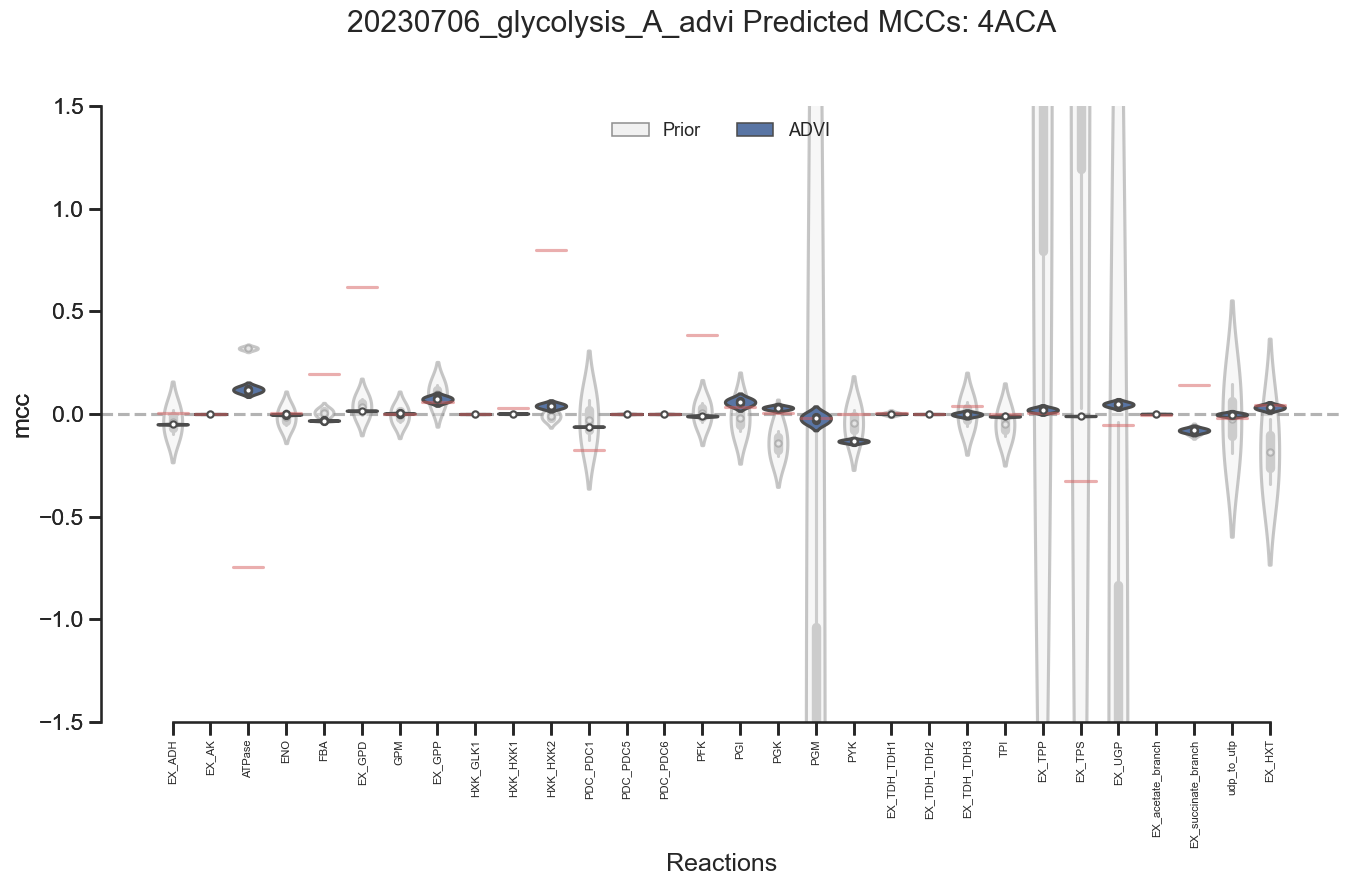

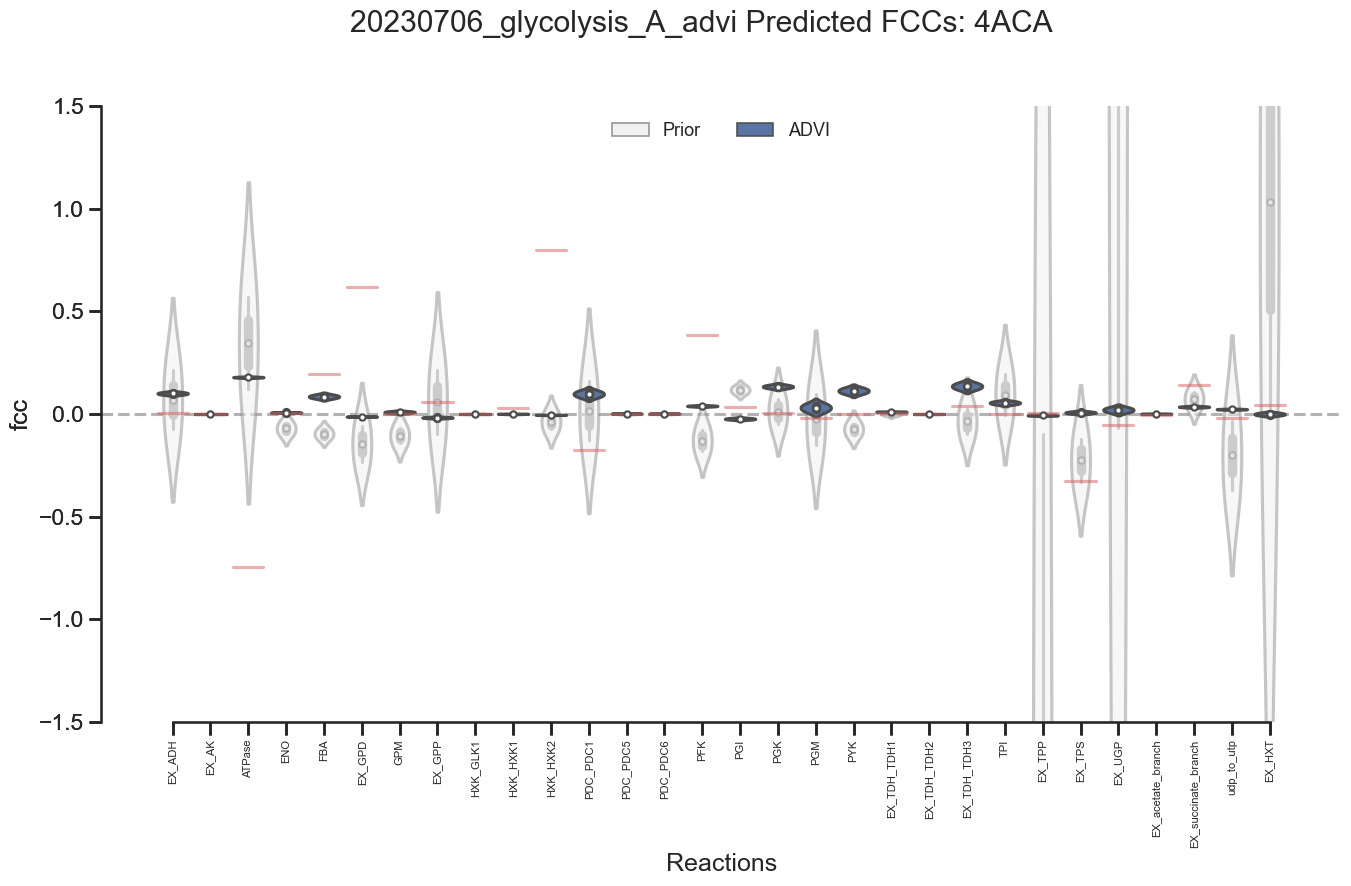

In [43]:
medians = ADVI_elasticities(pickle_jar)
mcc_df = ADVI_CCs_hdi(pickle_jar, medians, 'mcc', run_name)
plot_CC_distbs(mcc_df, 'mcc', '', run_name)
fcc_df = ADVI_CCs_hdi(pickle_jar, medians, 'fcc', run_name) # results_dir=f'{run_name}_FCCs.csv')
plot_CC_distbs(fcc_df, 'fcc', '', run_name)

In [9]:
# trace['posterior'].keys()
trace = pickle_jar['trace']
trace_prior = pickle_jar['trace_prior']
ll = pickle_jar['ll']
m_labels = pickle_jar['m_labels']
r_labels = pickle_jar['r_labels']
y_labels = ['co2_c', 'glc__D_c', 'h2o_c', 'h_c', 'nh4_c', 'o2_c', 'pi_c', 'pyr_c', 'succ_c', '4aPhe_c', '4acinna_c', '4aba_c', 'tCA_c', 'pHCA_c']

Ex_values = np.squeeze(trace['posterior']['Ex'].values) #np array
Ey_values = np.squeeze(trace['posterior']['Ey'].values)
vn_ss = np.squeeze(trace['posterior']['vn_ss'].values[0, :,0,:])

xn, vn = ll.steady_state_mat()

In [25]:
Ex_values.shape
from scipy import stats
modes, counts = stats.mode(Ex_values)
#np.squeeze(modes).shape
np.savetxt("median_Ex_May15_core66_y-err_120.csv", np.squeeze(modes), delimiter=",")


C:\Users\user\AppData\Local\Temp\ipykernel_13412\1035012421.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  modes, counts = stats.mode(Ex_values)


In [30]:
import tellurium as te
r = te.loads('../../pp_4aca_Ex66.xml')
link_mtx = r.getLinkMatrix()
reduced_mtx = r.getReducedStoichiometryMatrix()

In [114]:
def calculate_FCCs_link(Ex, v):
    A = np.matmul(reduced_mtx, Ex)
    A = np.matmul(A, link_mtx)
    B = np.linalg.inv(A)
    C = np.matmul(-link_mtx, B)
    C = np.matmul(C, reduced_mtx)
    unscaled = np.matmul(Ex, C) + np.identity(len(v))
    v[v == 0] = 1E-6
    D = np.diag (np.reciprocal(v))
    E = np.matmul(D, unscaled)
    return np.matmul(E, np.diag(v))


In [122]:
import tellurium as te
import roadrunner
import numpy as np
import scipy
r = te.loada("""
     A -> B; k1*A
     B -> A; k2*B
     A = 10
     k1 = 0.3; k2 = 0.5
""")
def calculate_FCCs_link(Ex, v):
    A = np.matmul(reduced_mtx, Ex)
    A = np.matmul(A, link_mtx)
    M = np.linalg.inv(A)
    C = np.matmul(-link_mtx, M)
    C = np.matmul(C, reduced_mtx)
    unscaled = np.matmul(Ex, C) + np.identity(len (v))
    D = np.diag (np.reciprocal(v))
    E = np.matmul(D, unscaled)
    return np.matmul(E, np.diag(v))
r.conservedMoietyAnalysis = True
r.steadyState()
link_mtx = r.getLinkMatrix()
reduced_mtx = r.getReducedStoichiometryMatrix()
k = calculate_FCCs_link(r.getScaledElasticityMatrix(), r.getReactionRates())
print ("calculated fcc = ")
print (k)
print (r.getScaledFluxControlCoefficientMatrix())

calculated fcc = 
 [[ 0.5, 0.5],
  [ 0.5, 0.5]]

         _J0,   _J1
_J0 [[ 0.625, 0.375],
_J1  [ 0.625, 0.375]]



In [115]:
link_mtx = r.getLinkMatrix()
reduced_mtx = r.getReducedStoichiometryMatrix()
k = calculate_FCCs_link(r.getUnscaledElasticityMatrix(), r.getReactionRates())

In [116]:
for row in k: 
    print(np.sum(row))

0.562895950269223
0.5628959502692228
1.2814479751346088
1.2814479751346124
1.2814479751346097
1.2814479751346126


In [83]:
fccs = np.array([calculate_FCCs_link(Ex=Ex_values[i], v=vn) for i in range(len(Ex_values))])

In [93]:
fcc_df = pd.DataFrame(fccs[0], columns=r_labels, index=r_labels)
# fcc_df

In [101]:
np.sum(fccs[462])

87.86820499904613

In [100]:
for i, mtx in enumerate(fccs):
    if np.sum(mtx) < 90 and np.sum(mtx) > 80:
        print(i)

462


In [103]:
g = fccs[462]
for i in range(len(g)):
    print(np.sum(g[i,:]))

0.5361050418501134
10.526265617121703
0.8206234455385509
-0.022635334310212623
6.6038074903284665
2.700411727492854
-26.15178224828041
-0.060552397787127774
-5.093725457478032
-0.5739448350309603
-0.5739448350311812
-0.5739448350311475
4.906965370203453
18.951116709650073
2.4674196899255927
1.6861854302780348
2.3138145697219197
1.668749608334244
1.7521561696731194
2.467419689925663
1.8658191480369652
1.0229741172392934
78.17697855246814
13.87463557780231
2.333078909943858
2.0655787161252914
2.7806730937509894
-5.373794655723543
0.7139884515880801
1.8415721454268958
3.500130020807135
4.4337099818819725
2.080740687990269
-8.686036024320494
2.3312503916657774
0.7139884515880338
2.29224743441617
1.597543917254053
0.7016842212784815
2.91115556449806
-0.09092898598183473
4.090928985982312
-0.09092898598203113
63.12296239538568
2.3138145697219534
4.477232535986443
1.6518822483979254
1.7521561696731165
4.47723253598648
-0.7372041655409215
18.951116709649888
-3.199456166682563
18.95111670965182

In [35]:
import tellurium as te
import roadrunner
import numpy as np
from scipy import linalg
r = te.loada("""
J1: -> s1; e1 * (k1-k2*s1)
J2: s1 -> s2; e2 * (k3*s1-k4*s2)
J3: s2 -> s3; e3 * (k5*s2-k6*s3)
J4: s2 -> s4; e4 * (k7*s2-k8*s4)
J5: s3 -> ; e5 * (k9*s3)
J6: s4 -> ; e6 * (k11*s4)

e1 = 1; e2 = 1; e3 = 1; e4 = 1; e5 = 1; e6 = 1;
k1 = 0.90151298; k2 = 0.5473373; k3 = 0.00164944; k4 = 0.53805831; k5 = 0.03635434; k6 = 0.85733177; 
k7 = 0.66081262; k8 = 0.55749815; k9 = 0.03199145; k11 = 0.6057181;
s1 = 0.2; s2 = 0.2; s3 = 0.4; s4 = 0.2;

""")
r.steadyState()
print (r.getUnscaledFluxControlCoefficientMatrix())
print (r.getUnscaledConcentrationControlCoefficientMatrix())

               J1,         J2,         J3,           J4,        J5,           J6
J1 [[  0.00117683,   0.390511,  0.0218827,     0.316765,   0.58643,     0.291548],
J2  [  0.00117683,   0.390511,  0.0218827,     0.316765,   0.58643,     0.291548],
J3  [ 4.45563e-06, 0.00147852,  0.0359195, -0.000772227,  0.962598, -0.000710751],
J4  [  0.00117238,   0.389032, -0.0140368,     0.317537, -0.376168,     0.292258],
J5  [ 4.45563e-06, 0.00147852,  0.0359195, -0.000772227,  0.962598, -0.000710751],
J6  [  0.00117238,   0.389032, -0.0140368,     0.317537, -0.376168,     0.292258]]

               J1,        J2,         J3,         J4,        J5,         J6
s1 [[     1.82488, -0.713474, -0.0399803,  -0.578738,  -1.07142,  -0.532665],
s2  [  0.00340705,   1.13057, -0.0407923,  -0.590492,  -1.09318,  -0.543484],
s3  [ 0.000139276, 0.0462162,    1.12278, -0.0241385,  -1.16914, -0.0222169],
s4  [  0.00193552,  0.642266, -0.0231737,   0.524232, -0.621028,   -1.16843]]



In [7]:
r.getReactionRates().shape

(6,)

In [43]:
np.sum(r.getUnscaledFluxControlCoefficientMatrix()[0])

1.6083123206182073

In [87]:
h = r.getScaledFluxControlCoefficientMatrix()

for i in range(h.shape[0]):
    print(np.sum(h[i, :]))


0.9999999999999739
1.0
1.0000000000000029
1.0
1.0
0.9999999999999999


In [ ]:
ll_link = emll.LinLogLinkMatrix(ll.N, ll.Ex, ll.Ey, ll.v_star)
fccs_link = np.array([ll_link.flux_control_coefficient(Ex=ex) for ex in Ex_values])

In [7]:
fccs = np.array([ll.flux_control_coefficient(Ex=ex) for ex in tqdm(Ex_values)])

100%|██████████| 1000/1000 [00:02<00:00, 368.31it/s]


In [8]:
r_med = np.median(fccs, 0).flatten()
l_med = np.median(fccs_link, 0).flatten()
r_err = [r_med - np.percentile(fccs, 25, axis=0).flatten(),
         np.percentile(fccs, 75, axis=0).flatten() - r_med]
l_err = [l_med - np.percentile(fccs_link, 25, axis=0).flatten(),
         np.percentile(fccs_link, 75, axis=0).flatten() - l_med]

Text(1, -1, '$\\rho = 0.96$')

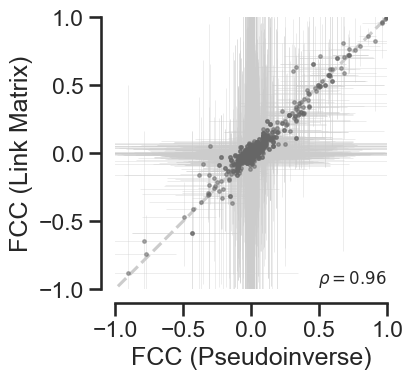

In [9]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='box')

ax.set_aspect('equal')
ax.errorbar(r_med, l_med, ms=5, lw=0, xerr=r_err, yerr=l_err,
            marker='.', color='.4', zorder=3, alpha=0.5)
ax.errorbar(r_med, l_med, ms=5, lw=0, xerr=r_err, yerr=l_err,
            elinewidth=.5, color='.8', alpha=0.5, zorder=2)

ax.plot([-5, 5], [-5, 5], '--', color='.8', zorder=0)

ax.set_xlabel('FCC (Pseudoinverse)')
ax.set_ylabel('FCC (Link Matrix)')

ax.set_rasterization_zorder(4)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])


plt.tight_layout()
sns.despine(trim=True, offset=10)
ax.text(1, -1, '$\\rho = {:.2f}$'.format(
    pd.Series(r_med).corr(pd.Series(l_med))), ha='right', va='bottom', fontsize=12)


In [12]:
fcc_med = np.median(fccs,0)
fcc_med = pd.DataFrame(fcc_med, columns=r_labels, index=r_labels)
fcc_med.to_csv('fcc_med-psj.csv')


In [ ]:
fccs_hpd = az.hdi(fccs)
pd.DataFrame(fccs_hpd, index=r_labels, columns=['lower', 'upper']).to_csv('fcc_hpd-psj.csv')

In [7]:
# Ex_values = pd.read_csv('Ex.csv')
vn_values = pd.read_csv('vn.csv').to_numpy()[1,1:] # (85,)
vn_values[vn_values == 0] = 1e-6
en_values = pd.read_csv('en.csv').to_numpy()[1, 1:] # (85,)
v_star = pd.read_csv('v_star.csv').to_numpy()[:,1] # (85,)

In [35]:
# pseudo-inverse method
def calculate_FCCs(ex):
    # Calculate the elasticity matrix at the new steady-state
    Ex_ss = np.diag(en_values / vn_values) @ ex
    Cx = -ll.solve(
                    ll.Nr @ np.diag(vn_values * v_star) @ Ex_ss,
                    ll.Nr @ np.diag(vn_values * v_star))
    Cv = np.eye(ll.nr) + Ex_ss @ Cx
    return Cv


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\arviz\data\base.py:221: UserWarning: More chains (1000) than draws (85). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [62]:
fccs = np.array([calculate_FCCs(ex) for ex in Ey_values])   
fcc_med = np.median(fccs,0)
fcc_med = pd.DataFrame(fcc_med, columns=r_labels, index=r_labels)
fcc_med.to_csv('fcc_med.csv')

fccs_hpd = az.hdi(fccs)
pd.DataFrame(fccs_hpd, index=r_labels, columns=['lower', 'upper']).to_csv('fcc_hpd.csv')

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\arviz\data\base.py:221: UserWarning: More chains (1000) than draws (85). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
